# **ESPIDAM: SIR Age-Structured Example With Vaccination**

***Authors: Sebastiaan Weytjens, Bram Silue, Pieter Libin, Niel Hens***

### **How to Run**
If you're having trouble running this code on your local machine, please open and run this notebook in Colab:

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/plibin/espidam-25/blob/main/sir/5_sir_age_vaccination_solution.ipynb)

We define some helper code that allows this notebook to run in both local environments and Google Colab:

In [1]:
import os
import urllib.request

def is_running_in_colab() -> bool:
    """
    Returns if the code is running inside Google Colab.

    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

def download_file(filepath: str, 
                  url: str) -> None:
    """
    Download a file from a URL if it does not exist locally. This is only 
    performed when running inside Google Colab.

    Arguments
    ---------
    filepath :  The local path (including subdirectories) where the file should be saved.
    url      :  The direct URL to download the file from.

    """
    if is_running_in_colab() and not os.path.exists(filepath):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        print(f"Downloading {filepath} from {url}")
        urllib.request.urlretrieve(url, filepath)

For Colab runs, we download the necessary files (i.e., helper functions, images, etc.):

In [2]:
if is_running_in_colab():
    download_file(filepath='utils/sir_helpers.py', url=f'https://raw.githubusercontent.com/plibin/espidam-25/main/sir/utils/sir_helpers.py')

### **Age-Structured SIR: Adding Vaccination**

To enable vaccination in the SIR model, we add two compartments: SV and IV, vaccinated susceptible and infected individuals, respectively. We modify the ODE equations as follows, where $\rho_i$ indicates the vaccination rate for age class i, $VE_S$ the susceptibility of vaccinated individuals, and $VE_I$ the infectiousness of vaccinated infected individuals:

$
\begin{aligned}
\frac{{dS_i}}{{dt}} &= - \rho_i \cdot S_i -\beta \cdot S_i \cdot \sum_j C_{i j} \cdot (I_j + VE_I \cdot IV_j) / N_j \\
\frac{{dSV_i}}{{dt}} &= \rho_i \cdot S_i -\beta \cdot VE_S \cdot SV_i \cdot \sum_j C_{i j} \cdot (I_j + VE_I \cdot IV_j) / N_j \\
\frac{{dI_i}}{{dt}} &= - \rho_i \cdot I_i - \gamma \cdot I_i + \beta \cdot S_i \cdot \sum_j C_{i j} \cdot (I_j + VE_I \cdot IV_j) / N_j \\
\frac{{dIV_i}}{{dt}} &= \rho_i \cdot I_i - \gamma \cdot IV_i + \beta \cdot VE_S \cdot SV_i \cdot \sum_j C_{i j} \cdot (I_j + VE_I \cdot IV_j) / N_j \\
\frac{{dR_i}}{{dt}} &= \gamma \cdot I_i + \gamma \cdot IV_i
\end{aligned}
$

### **Dependencies**
First, make sure to install miniconda and the necessary libraries as specified in [`README.md`](README.md). After that, we import the necessary libraries and dependencies as follows:

In [3]:
import numpy as np
from numpy.linalg import eig
from scipy.integrate import odeint
from utils.sir_helpers import *

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

### **Model Description**
We will start with the model description. Again, we give you a head start by filling in the compartments, the contact matrix and the initial compartment values. Complete the force of infection and the required rates.

In [4]:
# Compartments.
compartments = {
    "S_c":  [],
    "SV_c": [],
    "I_c":  [],
    "IV_c": [],
    "R_c":  [],
    "S_a":  [],
    "SV_a": [],
    "I_a":  [],
    "IV_a": [],
    "R_a":  [],
}


# Contact matrix.
def contacts(i: int, j: int) -> int:
    """
    Returns the average number of contacts between age groups.

    Arguments
    ---------
    i :  The index of the receiving age group.
    j :  The index of the contacting age group.

    Returns
    -------
    The average number of contacts from group j to group i.

    """
    contact_matrix = [
        [18, 9],
        [3, 12],
    ]
    return contact_matrix[i][j]


# Transition rates.
def foi(I: list, Iv: list, params: dict, Ns: list, ac_idx: int, acs: int) -> float:
    """
    Computes the force of infection for a given age group, accounting for vaccinated infectives.

    Arguments
    ---------
    I      :  A list of unvaccinated infected individuals per age group.
    Iv     :  A list of vaccinated infected individuals per age group.
    params :  A dictionary containing model parameters.
    Ns     :  A list of population sizes per age group.
    ac_idx :  The index of the current age class.
    acs    :  The total number of age classes.

    Returns
    -------
    foi_value :  The force of infection for the specified age group.

    """
    foi_value = 0

    # SOLUTION: FOI calculation including vaccinated infectives.
    for ac_j in range(acs):
        contact = contacts(ac_idx, ac_j)
        infectious = I[ac_j] + params["ve_i"] * Iv[ac_j]
        foi_value += params["beta"] * contact * infectious / Ns[ac_j]

    return foi_value


def i_r(params: dict) -> float:
    """
    Computes the recovery rate.

    Arguments
    ---------
    params :  The dictionary containing model parameters (expects key 'gamma').

    Returns
    -------
    The recovery rate.

    """
    # SOLUTION: I to R rate.
    return params["gamma"]


def i_iv(params: dict, ac_idx: int) -> float:
    """
    Returns the vaccination rate for infected individuals based on age class.

    Arguments
    ---------
    params :  The dictionary containing model parameters.
    ac_idx :  The index of the age class (0 for children, 1 for adults).

    Returns
    -------
    The vaccination rate for infected individuals in the given age class.

    """
    # SOLUTION: Vaccination rate, dependent on age class.
    ac = 'c' if ac_idx == 0 else 'a'
    return params[f"rho_{ac}"]


def s_sv(params: dict, ac_idx: int) -> float:
    """
    Returns the vaccination rate for susceptible individuals based on age class.

    Arguments
    ---------
    params :  The dictionary containing model parameters.
    ac_idx :  The index of the age class (0 for children, 1 for adults).

    Returns
    -------
    The vaccination rate for susceptible individuals in the given age class.

    """
    # SOLUTION: Vaccination rate, dependent on age class.
    ac = 'c' if ac_idx == 0 else 'a'
    return params[f"rho_{ac}"]


def initialise_modelstate(modelstate: dict, seeds: int, N_c: int, N_a: int) -> dict:
    """
    Initialises the model state including vaccination compartments.

    Arguments
    ---------
    modelstate :  A dictionary to hold compartment values over time.
    seeds      :  The initial number of infected individuals per group.
    N_c        :  The total population size of children.
    N_a        :  The total population size of adults.

    Returns
    -------
    modelstate :  The updated model state dictionary.

    """
    modelstate["S_c"]  = [N_c - seeds]
    modelstate["SV_c"] = [0]
    modelstate["I_c"]  = [seeds]
    modelstate["IV_c"] = [0]
    modelstate["R_c"]  = [0]

    modelstate["S_a"]  = [N_a - seeds]
    modelstate["SV_a"] = [0]
    modelstate["I_a"]  = [seeds]
    modelstate["IV_a"] = [0]
    modelstate["R_a"]  = [0]

    return modelstate


### **Solvers for the model**
Next, we will use ODEs to simulate our model. We complete the `ode_system` function with the correct calculations.

In [5]:
def ode_system(y0: tuple, t: float, parameters: dict) -> tuple:
    """
    Defines the ODE system for a two-age-group SIRV model with vaccination.

    Arguments
    ---------
    y0         :  A tuple of initial values for all compartments.
    t          :  The current time point (required by `odeint`, but unused internally).
    parameters :  A dictionary containing 'disease_params' and population sizes 'Ns'.

    Returns
    -------
    The derivatives of all compartments as a tuple.

    """
    params = parameters["disease_params"]
    Ns     = parameters["Ns"]

    s_c, sv_c, i_c, iv_c, r_c, s_a, sv_a, i_a, iv_a, r_a = y0
    ds_c, dsv_c, di_c, div_c, dr_c = 0, 0, 0, 0, 0
    ds_a, dsv_a, di_a, div_a, dr_a = 0, 0, 0, 0, 0

    # SOLUTION: Calculate dynamics for children.
    foi_c = foi([i_c, i_a], [iv_c, iv_a], params, Ns, 0, 2)
    ds_c   += -foi_c * s_c - s_sv(params, 0) * s_c
    dsv_c  += s_sv(params, 0) * s_c - foi_c * sv_c * params["ve_s"]
    di_c   += foi_c * s_c - i_r(params) * i_c - i_iv(params, 0) * i_c
    div_c  += i_iv(params, 0) * i_c - i_r(params) * iv_c + foi_c * sv_c * params["ve_s"]
    dr_c   += i_r(params) * i_c + i_r(params) * iv_c

    # SOLUTION: Calculate dynamics for adults.
    foi_a = foi([i_c, i_a], [iv_c, iv_a], params, Ns, 1, 2)
    ds_a   += -foi_a * s_a - s_sv(params, 1) * s_a
    dsv_a  += s_sv(params, 1) * s_a - foi_a * sv_a * params["ve_s"]
    di_a   += foi_a * s_a - i_r(params) * i_a - i_iv(params, 1) * i_a
    div_a  += i_iv(params, 1) * i_a - i_r(params) * iv_a + foi_a * sv_a * params["ve_s"]
    dr_a   += i_r(params) * i_a + i_r(params) * iv_a

    return ds_c, dsv_c, di_c, div_c, dr_c, ds_a, dsv_a, di_a, div_a, dr_a


def ode_solver(model_state: dict, end_t: int, params: dict, Ns: list) -> dict:
    """
    Solves the SIRV model with vaccination using ordinary differential equations.

    Arguments
    ---------
    model_state :  The initial state of all compartments.
    end_t       :  The number of time steps to simulate.
    params      :  A dictionary of model parameters.
    Ns          :  A list of population sizes for each age group.

    Returns
    -------
    new_model_state :  The model state over time for all compartments.

    """
    all_parameters = {
        "disease_params": params,
        "Ns": Ns,
    }

    # Initial conditions and time vector.
    y0 = (
        model_state["S_c"][0],  model_state["SV_c"][0],
        model_state["I_c"][0],  model_state["IV_c"][0],
        model_state["R_c"][0],  model_state["S_a"][0],
        model_state["SV_a"][0], model_state["I_a"][0],
        model_state["IV_a"][0], model_state["R_a"][0]
    )
    t = np.linspace(0, end_t, end_t)

    # Solving the ODE system.
    ret = odeint(ode_system, y0, t, args=(all_parameters,))
    s_c, sv_c, i_c, iv_c, r_c, s_a, sv_a, i_a, iv_a, r_a = ret.T

    new_model_state = {
        "S_c":   list(s_c),
        "SV_c":  list(sv_c),
        "I_c":   list(i_c),
        "IV_c":  list(iv_c),
        "R_c":   list(r_c),
        "S_a":   list(s_a),
        "SV_a":  list(sv_a),
        "I_a":   list(i_a),
        "IV_a":  list(iv_a),
        "R_a":   list(r_a),
    }

    return new_model_state

### **Model Parameters**
If you implemented everything correctly, you can use the parameters below to simulate your age-structured SIR model with vaccinations.

In [6]:
# Population and initial conditions.
N = 1_000_000       # total population
N_c = 0.25 * N      # population of children
N_a = 0.75 * N      # population of adults
seeds = 1           # initial number of infected individuals

# Disease parameters.
gamma = 1/7         # recovery rate (1 / infectious period)
R0 = 3              # basic reproduction number
f = [0.25, 0.75]    # fraction of children and adults in the population

# Normalised contact matrix.
m = np.array([
    [18 * f[0] / f[0],  9 * f[0] / f[1]],
    [ 3 * f[1] / f[0], 12 * f[1] / f[1]],
])
spectral_radius = max(eig(m)[0])  # spectral radius of the contact matrix

# Model parameters.
params = {
    "beta":  R0 * gamma / spectral_radius,  # transmission rate
    "gamma": gamma,                         # recovery rate
    "ve_s":  0.4,                           # susceptibility of vaccinated individuals
    "ve_i":  0.5,                           # infectivity of vaccinated infected individuals
    "rho_c": 0.01,                          # daily vaccination rate of children
    "rho_a": 0.01,                          # daily vaccination rate of adults
}

# Simulation settings.
end_t = 150  # number of days to simulate


### **Vaccination Scenarios**
Below you can run a scenario with vaccination for adults and children as defined above in the parameters code section. We plot the infected and vaccinated infected individuals over time, both for children and adults.

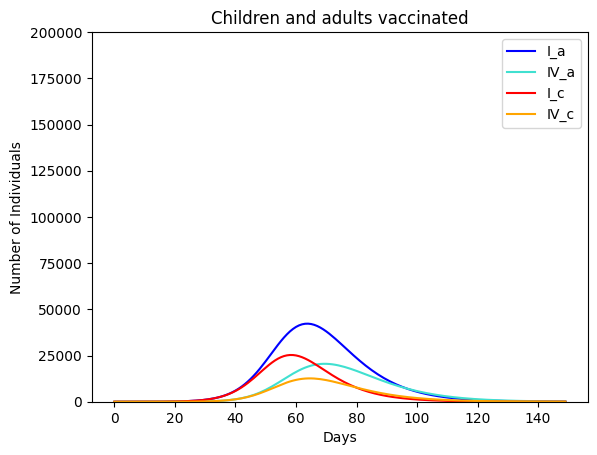

In [7]:
modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

plot_ODE_w_vacc(results, "Children and adults vaccinated", 200_000)

##### **Decreased infectivity for vaccinated individuals**

Let us assume that vaccinated infected individuals are less infectious than defined in the previous section. Adjust the parameters, perform a simulation and interpret the results as we did in the previous scenario. How did this affect the disease outcome?

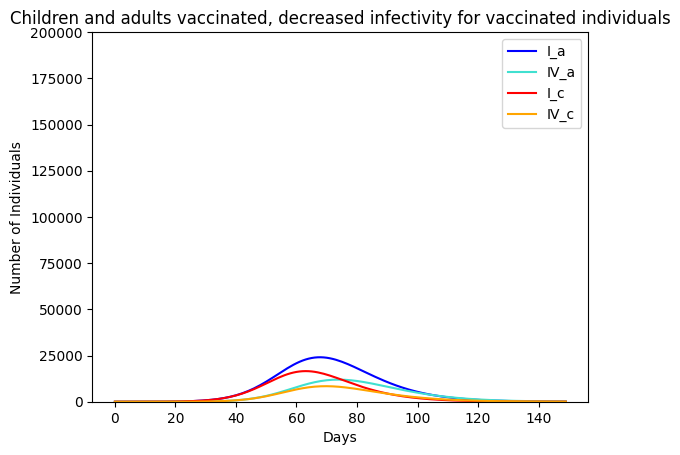

In [8]:
params["ve_i"] = 0.1

modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

plot_ODE_w_vacc(results, "Children and adults vaccinated, decreased infectivity for vaccinated individuals", 200_000)

### **Vaccine Policies**

Reset the parameters to the initial configuration. Now, let's compare what happens when we vaccinate children vs adults, what are the differences in attack rate?

##### **Only adults vaccinated**

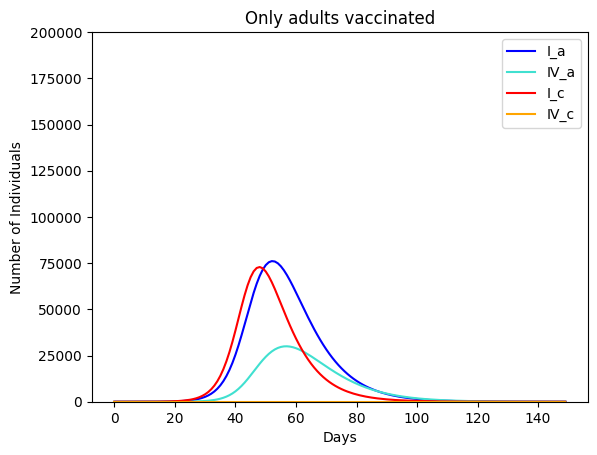

In [9]:
params["ve_i"] = 0.5
params["ve_s"] = 0.4
params["rho_c"] = 0

modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

plot_ODE_w_vacc(results, "Only adults vaccinated", 200_000)

##### **Only children vaccinated**

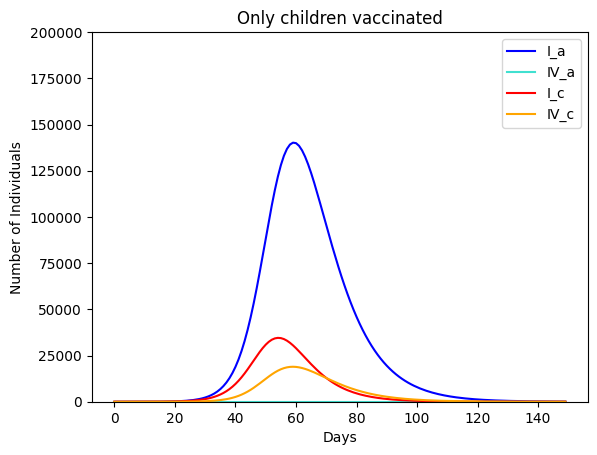

In [10]:
params["ve_i"] = 0.4
params["ve_s"] = 0.5
params["rho_c"] = 0.01
params["rho_a"] = 0

modelstate = initialise_modelstate(compartments, seeds, N_c, N_a)
results = ode_solver(modelstate, end_t, params, [N_c, N_a])

plot_ODE_w_vacc(results, "Only children vaccinated", 200_000)